In [1]:
#!pip install gcm-filters -q

In [2]:
#!pip install gsw -q

# Dask start

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:55845")
client

<Client: 'tcp://127.0.0.1:55845' processes=4 threads=8, memory=16.00 GiB>

# Import

In [4]:
#import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage

# Load data

Choose cases

In [5]:
data=[dict(),dict()]

In [6]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'Gulf Stream'})
data[1] = dict({'region' : '3', 'season' : 'fma', 'label' : 'West Medit'})

## eNATL60

In [7]:
# from validate_catalog import all_params
# params_dict, cat = all_params()

In [8]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,12),y=y_slice,x=x_slice)  # take every 50-th hourly output
coord_slice = dict(y=y_slice,x=x_slice)

In [9]:
nb_of_time_chunks = 7

In [10]:
%%time
for i in range(len(data)) :
    #current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.load()
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set

CPU times: user 138 ms, sys: 115 ms, total: 253 ms
Wall time: 2.12 s


## Time-averaged eNATL60

In [11]:
resampling_avg_period = '2208h'  # 92 days

In [12]:
%%time
for i in range(len(data)) :
    #current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, current_set['sosaline'], current_set['sosstsst'], dask='parallelized')
    #current_set['sigma0'] = xr.apply_ufunc(gsw.density.sigma0, current_set['sosaline'], current_set['CT'], dask='parallelized')
    current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    #current_set = current_set.mean(dim='time_counter')
    #current_set = current_set.isel(data_slice)
    #current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.load()
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR_avg'] = current_set

CPU times: user 133 ms, sys: 53.6 ms, total: 187 ms
Wall time: 3.32 s


## eORCA025

In [13]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_dataset("/Users/ana/data/eNATL60_extractions/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    rename(nav_lat='lat', nav_lon='lon')

# Compare

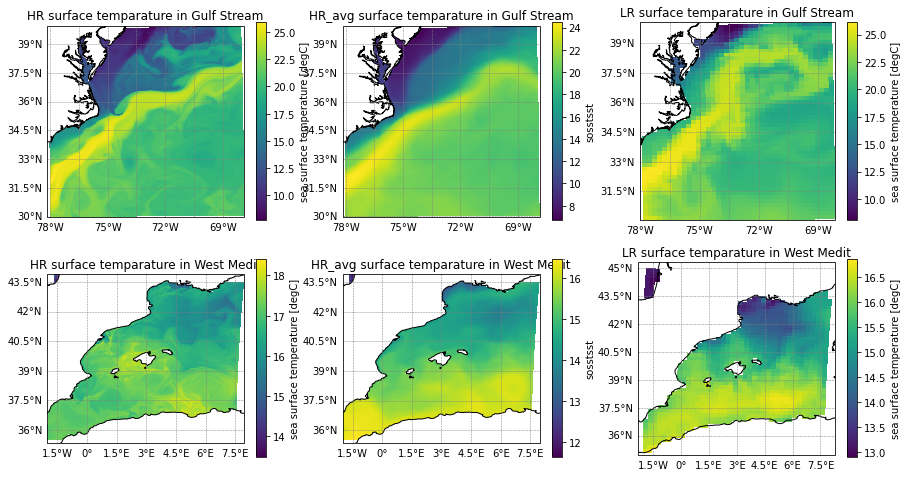

In [14]:
fig, axis = plt.subplots(ncols=3, nrows=2, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
for region in [0,1] :
    for col, dataSetKey in enumerate(['HR', 'HR_avg','LR']) :
        row = region 
        data[region][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' surface temparature in ' + data[region]['label'])

for ax in axis.flatten() :
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

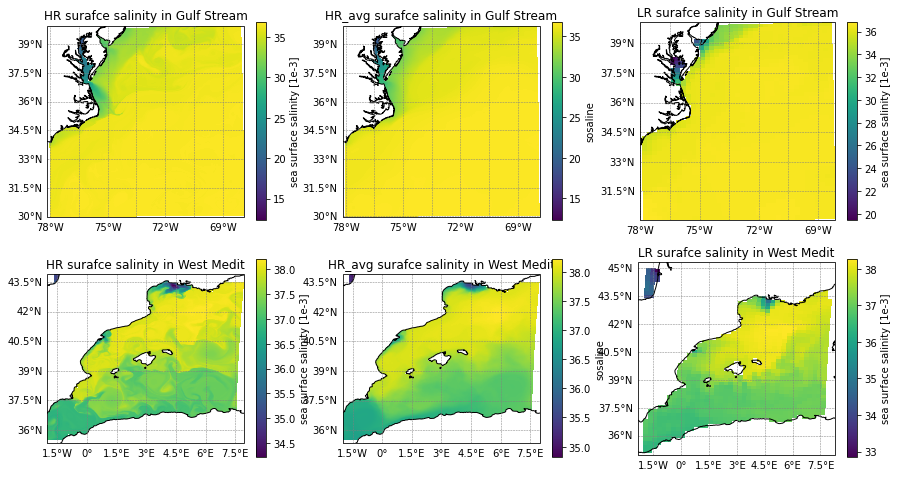

In [15]:
fig, axis = plt.subplots(ncols=3, nrows=2, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
for region in [0,1] :
    for col, dataSetKey in enumerate(['HR', 'HR_avg', 'LR']) :
        row = region 
        data[region][dataSetKey].isel(time_counter=-1).sosaline[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' surafce salinity in ' + data[region]['label'])

for ax in axis.flatten() :
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# Density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library:

In [16]:
%%time
for region in range(len(data)) :
    for dataKey in ['HR', 'HR_avg', 'LR'] :
        data[region][dataKey]['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, data[region][dataKey]['sosaline'], data[region][dataKey]['sosstsst'], dask='parallelized').compute()
        data[region][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[region][dataKey]['sosaline'], data[region][dataKey]['CT'], dask='parallelized').compute()

CPU times: user 549 ms, sys: 139 ms, total: 688 ms
Wall time: 598 ms


# Filter data

Parameters (to determine) :

In [17]:
filter_coef = 12      # filter coefficient (size gaussian kernel relative to the grid size)
coarsening_window_size = 12

In [18]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    new_e2t = data['e2t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binariwe and erode the mask (to remove isolated pixels)
    threshold = 0.9
    new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    # apply new mask to data
    result = result.where(result.tmask>0)
    return result

In [19]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=dataHR.coords)
        data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    else :
        data_filtered = dataHR
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Without time averaging

Filter + coarsening:

In [20]:
%%time
for i in [0,1] : 
    data[i]['HR_Filtered'] = apply_filter_downsample(data[i]['HR'], filter_coef, coarsening_window_size).compute().\
    chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

CPU times: user 31.5 s, sys: 15.7 s, total: 47.2 s
Wall time: 47.2 s


Only coarsening:

In [21]:
%%time
for i in [0,1] : 
    data[i]['HR_Coarsened'] = apply_filter_downsample(data[i]['HR'], 0, coarsening_window_size).compute().\
    chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

CPU times: user 448 ms, sys: 118 ms, total: 566 ms
Wall time: 565 ms


In [22]:
x_slice = slice(0,-1)
y_slice = slice(2,-1)

bord_cut = dict(y=y_slice,x=x_slice) # to cut borders 

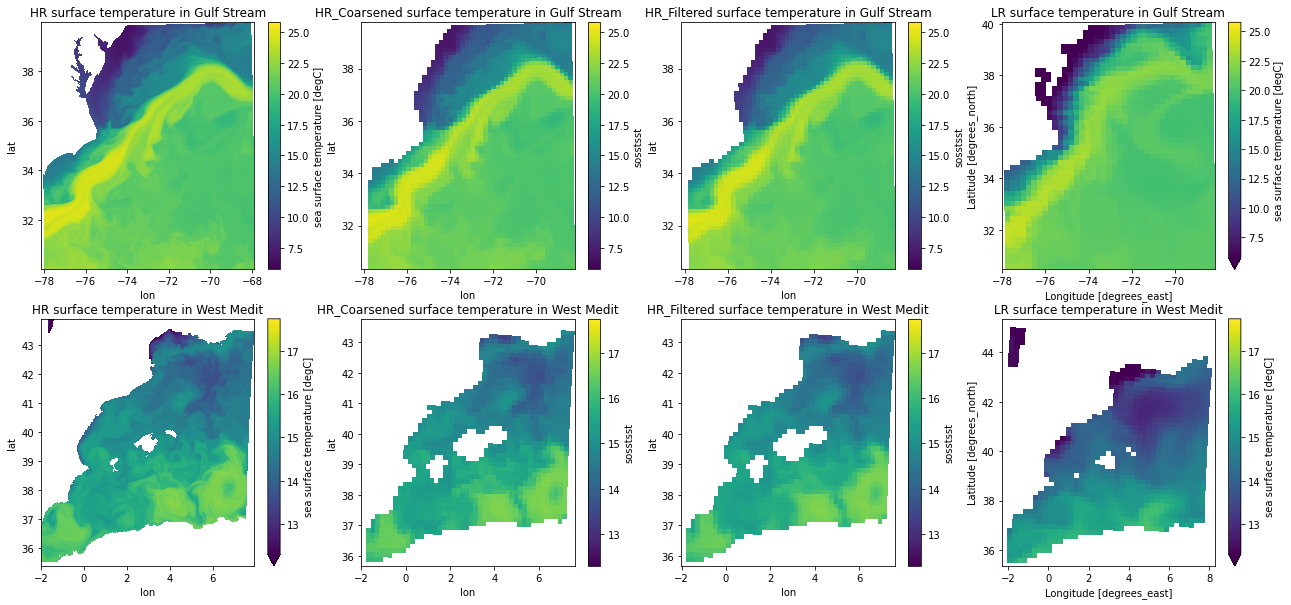

In [23]:
fig, axis = plt.subplots(ncols=4, nrows=2, figsize=(22,10))
for region in [0,1] :
    norm = colors.Normalize(vmin=data[region]['HR_Coarsened'].isel(time_counter=0).sosstsst.min().values-1, \
                            vmax=data[region]['HR_Coarsened'].isel(time_counter=0).sosstsst.max().values+1)
    for col, dataSetKey in enumerate(['HR', 'HR_Coarsened', 'HR_Filtered', 'LR']) :
        row = region 
        data[region][dataSetKey].isel(time_counter=0).sosstsst[bord_cut].plot(x='lon', y='lat', ax=axis[row,col], norm=norm)
        axis[row,col].set(title=dataSetKey + ' surface temperature in ' + data[region]['label'])

## With time averaging

In [24]:
%%time
for i in [0,1] : 
    data[i]['HR_Avg_Filtered'] = apply_filter_downsample(data[i]['HR_avg'], filter_coef, coarsening_window_size).compute().chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    data[i]['HR_Avg_Coarsened'] = apply_filter_downsample(data[i]['HR_avg'], 0, coarsening_window_size).compute().chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

CPU times: user 4.15 s, sys: 814 ms, total: 4.97 s
Wall time: 4.97 s


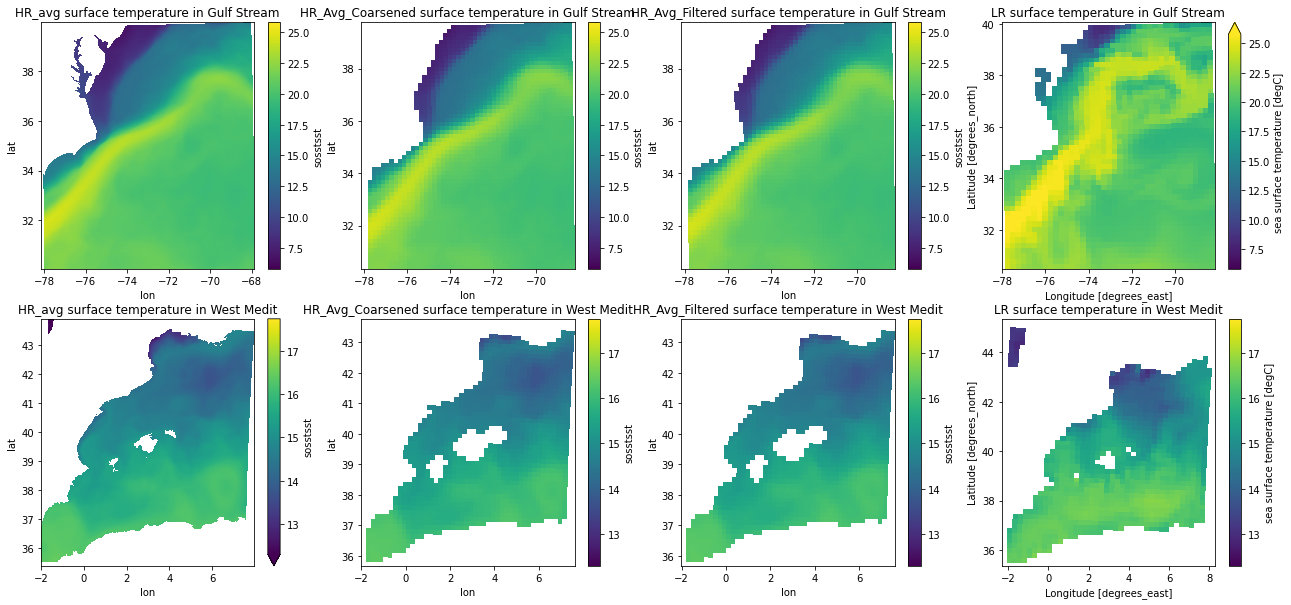

In [25]:
fig, axis = plt.subplots(ncols=4, nrows=2, figsize=(22,10))
for region in [0,1] :
    norm = colors.Normalize(vmin=data[region]['HR_Coarsened'].isel(time_counter=0).sosstsst.min().values-1, \
                            vmax=data[region]['HR_Coarsened'].isel(time_counter=0).sosstsst.max().values+1)
    for col, dataSetKey in enumerate(['HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered', 'LR']) :
        row = region 
        data[region][dataSetKey].isel(time_counter=-1).sosstsst[bord_cut].plot(x='lon', y='lat', ax=axis[row,col], norm=norm)
        axis[row,col].set(title=dataSetKey + ' surface temperature in ' + data[region]['label'])

# Density correction

Low-resolution density

In [26]:
%%time
for region in range(len(data)) :
    for dataKey in ['HR_Coarsened', 'HR_Filtered', 'HR_Avg_Coarsened', 'HR_Avg_Filtered'] :
        data[region][dataKey]['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, data[region][dataKey]['sosaline'], data[region][dataKey]['sosstsst'], dask='parallelized').compute()
        data[region][dataKey]['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, data[region][dataKey]['sosaline'], data[region][dataKey]['CT'], dask='parallelized').compute()
        data[region][dataKey]['sigma0_delta'] = (data[region][dataKey]['sigma0_true'] - data[region][dataKey]['sigma0_model'])

CPU times: user 146 ms, sys: 15.7 ms, total: 162 ms
Wall time: 518 ms


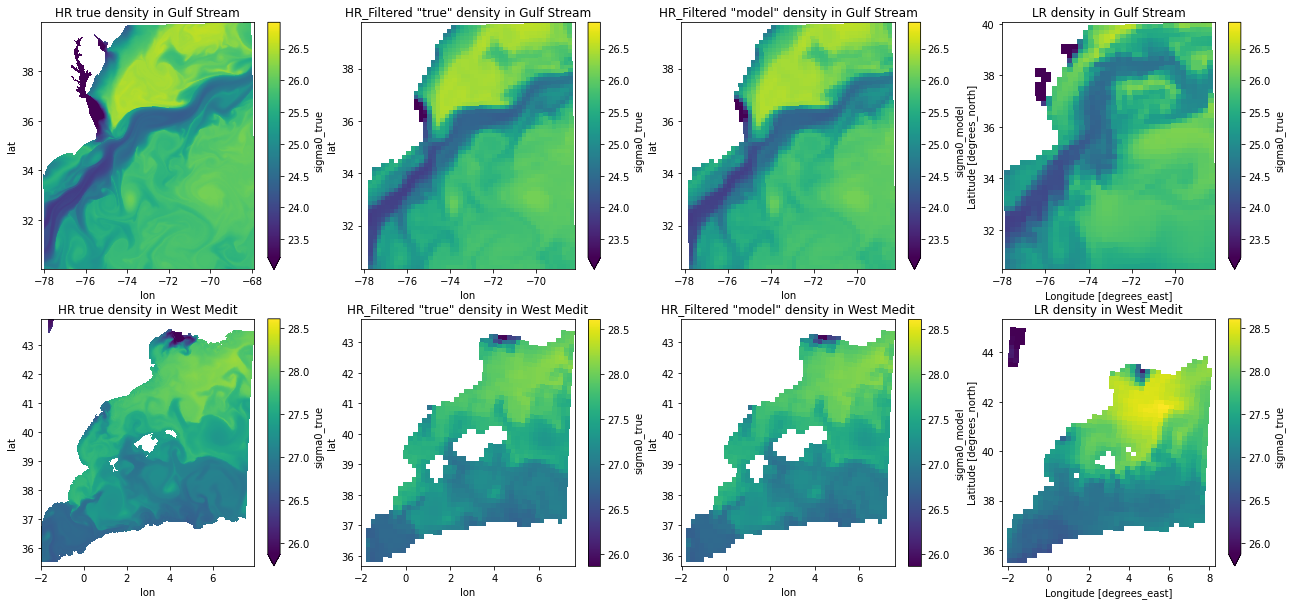

In [27]:
fig, axis = plt.subplots(ncols=4, nrows=2, figsize=(22,10))
for region in [0,1] :
    norm = colors.Normalize(vmin=data[region]['HR_Coarsened'].isel(time_counter=0).sigma0_true.min().values-1, \
                            vmax=data[region]['HR_Coarsened'].isel(time_counter=0).sigma0_true.max().values)
    row = region 
    data[region]['HR'].isel(time_counter=-1).sigma0_true[bord_cut].plot(x='lon', y='lat', ax=axis[row,0], norm=norm)
    axis[row,0].set(title='HR true density in ' + data[region]['label'])
        
    data[region]['HR_Filtered'].isel(time_counter=-1).sigma0_true[bord_cut].plot(x='lon', y='lat', ax=axis[row,1], norm=norm)
    axis[row,1].set(title='HR_Filtered "true" density in ' + data[region]['label'])
    
    data[region]['HR_Filtered'].isel(time_counter=-1).sigma0_model[bord_cut].plot(x='lon', y='lat', ax=axis[row,2], norm=norm)
    axis[row,2].set(title='HR_Filtered "model" density in ' + data[region]['label'])
    
    data[region]['LR'].isel(time_counter=-1).sigma0_true[bord_cut].plot(x='lon', y='lat', ax=axis[row,3], norm=norm)
    axis[row,3].set(title=r'LR density in ' + data[region]['label'])

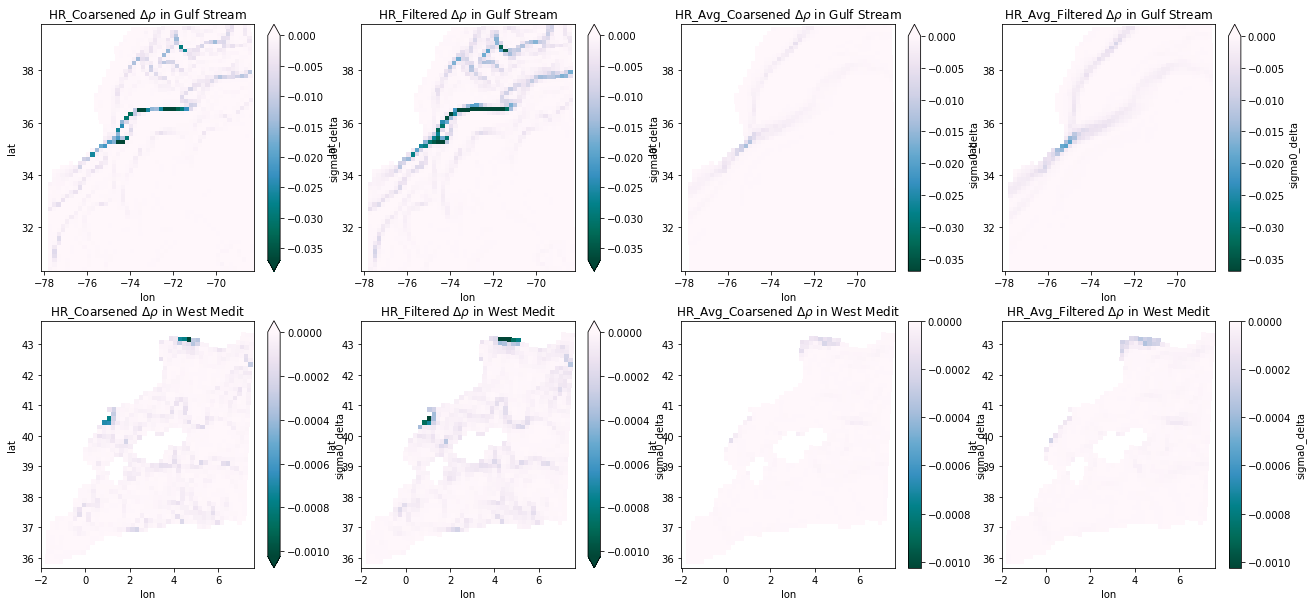

In [28]:
fig, axis = plt.subplots(ncols=4, nrows=2, figsize=(22,10))
selected_cmap = 'PuBuGn_r'
for region in [0,1] :
    norm = colors.Normalize(vmin=0.75*data[region]['HR_Filtered'].isel(time_counter=0).sigma0_delta.min().values, \
                            vmax=data[region]['HR_Filtered'].isel(time_counter=0).sigma0_delta.max().values)
    row = region 
    for col, dataSetKey in enumerate(['HR_Coarsened', 'HR_Filtered', 'HR_Avg_Coarsened', 'HR_Avg_Filtered']) :
        data[region][dataSetKey].isel(time_counter=-1).sigma0_delta[bord_cut].plot(x='lon', y='lat', ax=axis[row,col], cmap=selected_cmap, norm=norm)
        axis[row,col].set(title=dataSetKey + r' $\Delta \rho$ in ' + data[region]['label'])

# Derivatives of density from EOS

 Derivatives of density with respect to temperature and salinity:

In [29]:
%%time
for region in range(len(data)) :
    for dataKey in ['HR_Coarsened', 'HR_Filtered', 'HR_Avg_Coarsened', 'HR_Avg_Filtered', 'LR'] :
        ds = data[region][dataKey]
        ds["alpha"], ds["beta"] = eos_module.alpha_beta(ds["sosaline"], ds["CT"])
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['CT'])

CPU times: user 2.26 s, sys: 27.6 ms, total: 2.28 s
Wall time: 2.28 s


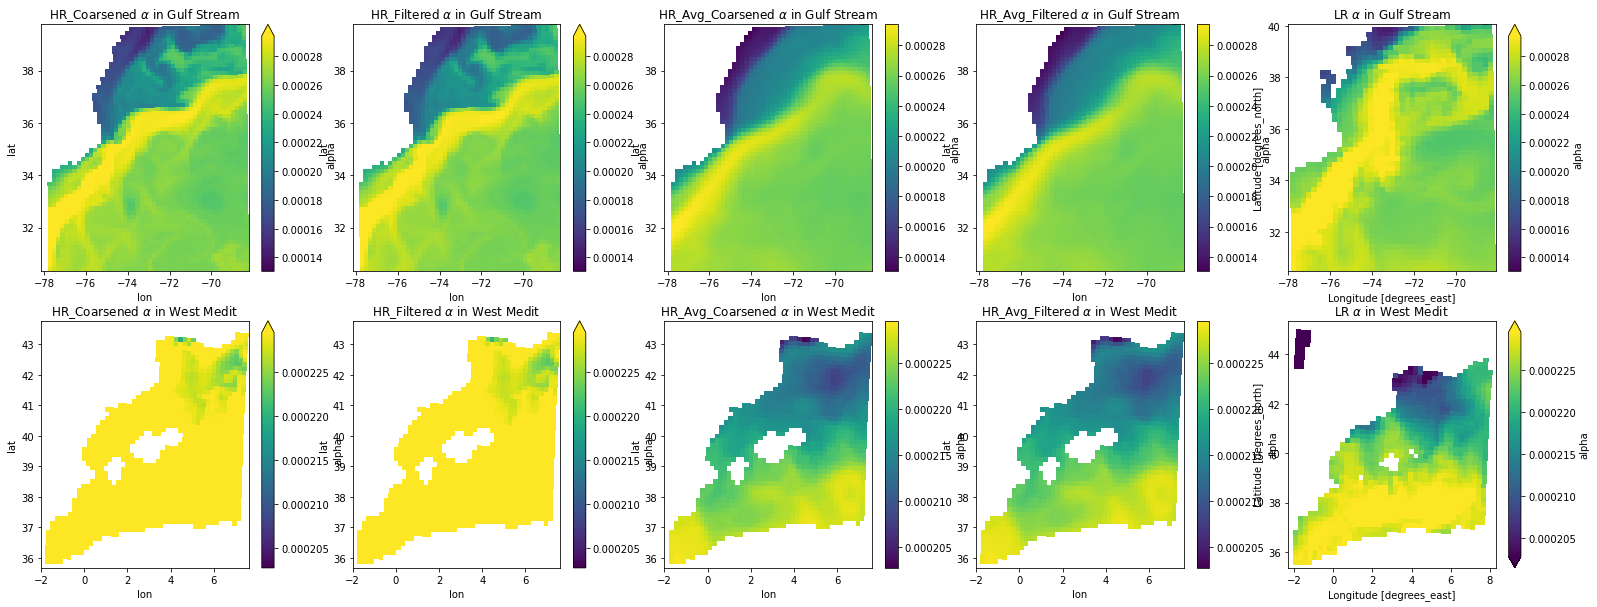

In [30]:
fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(27,10))
for region in [0,1] :
    norm = colors.Normalize(vmin=data[region]['HR_Avg_Coarsened'].isel(time_counter=0).alpha.min().values, \
                            vmax=data[region]['HR_Avg_Coarsened'].isel(time_counter=0).alpha.max().values)
    row = region 
    for col, dataSetKey in enumerate(['HR_Coarsened', 'HR_Filtered', 'HR_Avg_Coarsened', 'HR_Avg_Filtered', 'LR']) :
        data[region][dataSetKey].isel(time_counter=-1).alpha[bord_cut].plot(x='lon', y='lat', ax=axis[row,col], norm=norm, cmap='viridis')
        axis[row,col].set(title=dataSetKey + r' $\alpha$ in ' + data[region]['label'])

# Spatial derivatives of temperature and salinity

In [31]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [32]:
def diffs_x(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffs_y(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [33]:
def add_spatial_grad_to_dataset(input_dataset) :
    return xr.merge([input_dataset,
                      xr.DataArray(gradx(input_dataset.sosstsst, input_dataset.e1t), name='gradx_temp'),
                      xr.DataArray(grady(input_dataset.sosstsst, input_dataset.e2t), name='grady_temp'),
                      xr.DataArray(gradx(input_dataset.sosaline, input_dataset.e1t), name='gradx_sal'),
                      xr.DataArray(grady(input_dataset.sosaline, input_dataset.e2t), name='grady_sal'),                      
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosstsst, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosstsst, input_dataset.e2t)**2), name='grad_temp'),
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosaline, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosaline, input_dataset.e2t)**2), name='grad_sal'),\
                      xr.DataArray((gradx(input_dataset.sosstsst, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosstsst, input_dataset.e2t)**2), name='grad_temp_sqr'),
                      xr.DataArray((gradx(input_dataset.sosaline, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosaline, input_dataset.e2t)**2), name='grad_sal_sqr')],compat='override')

In [34]:
%%time
for region in [0,1] :
    for dataSetKey in ['HR', 'HR_Coarsened', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered'] :
        data[region][dataSetKey] = add_spatial_grad_to_dataset(data[region][dataSetKey][bord_cut]).compute().chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

CPU times: user 2.8 s, sys: 616 ms, total: 3.41 s
Wall time: 4.43 s


In [35]:
#non_dim_density = 0.05

In [36]:
%%time
for region in range(len(data)) :
    for dataKey in ['HR_Coarsened', 'HR_Filtered', 'HR_Avg_Coarsened', 'HR_Avg_Filtered', 'LR'] :
        ds = data[region][dataKey]
        ds['alpha_nablaT'] = (ds['alpha']*np.sqrt(gradx(ds['CT'], ds['e1t'])**2 + grady(ds['CT'], ds['e2t'])**2)).compute()
        ds['beta_nablaS'] = (ds['beta']*np.sqrt(gradx(ds['sosaline'], ds['e1t'])**2 + grady(ds['sosaline'], ds['e2t'])**2)).compute()
        ds['spicyness'] = ds['alpha_nablaT'] + ds['beta_nablaS']
        ds['buoyancy'] = ds['alpha_nablaT'] - ds['beta_nablaS']

CPU times: user 385 ms, sys: 21.5 ms, total: 407 ms
Wall time: 1.2 s


In [37]:
%%time
# second order
for region in range(len(data)) :
    for dataKey in ['HR_Coarsened', 'HR_Filtered', 'HR_Avg_Coarsened', 'HR_Avg_Filtered', 'LR'] :
        ds = data[region][dataKey]
#         ds['non_dim_temp_var'] = 0.5*(ds['rho_ct_ct']*(diffs_x(ds['CT'])**2 + diffs_y(ds['CT'])**2)).compute()
#         ds['non_dim_mix_var'] = (ds['rho_sa_ct']*np.sqrt(diffs_x(ds['CT'])**2 + diffs_y(ds['CT'])**2)*np.sqrt(diffs_x(ds['sosaline'])**2 + diffs_y(ds['sosaline'])**2)).compute()
#         ds['non_dim_sal_var'] = 0.5*(ds['rho_sa_sa']*(diffs_x(ds['sosaline'])**2 + diffs_y(ds['sosaline'])**2)).compute()      
#         ds['non_dim_var_total'] = 1./non_dim_density*(ds['non_dim_temp_var'] + ds['non_dim_mix_var'] + ds['non_dim_sal_var'])                    
        ds['temp_second_deriv'] = (ds['rho_ct_ct']*(gradx(ds['CT'], ds['e1t'])**2 + grady(ds['CT'], ds['e2t'])**2)).compute()
        ds['mixed_second_deriv'] = (ds['rho_sa_ct']*np.sqrt(gradx(ds['CT'], ds['e1t'])**2 + grady(ds['CT'], ds['e2t'])**2)*np.sqrt(gradx(ds['sosaline'], ds['e1t'])**2 + grady(ds['sosaline'], ds['e2t'])**2)).compute()
        ds['sal_second_deriv'] = (ds['rho_sa_sa']*(gradx(ds['sosaline'], ds['e1t'])**2 + grady(ds['sosaline'], ds['e2t'])**2)).compute()
        ds['total_second_deriv'] = ds['temp_second_deriv']+2.*ds['mixed_second_deriv']+ds['sal_second_deriv']

CPU times: user 639 ms, sys: 39.2 ms, total: 678 ms
Wall time: 1.78 s


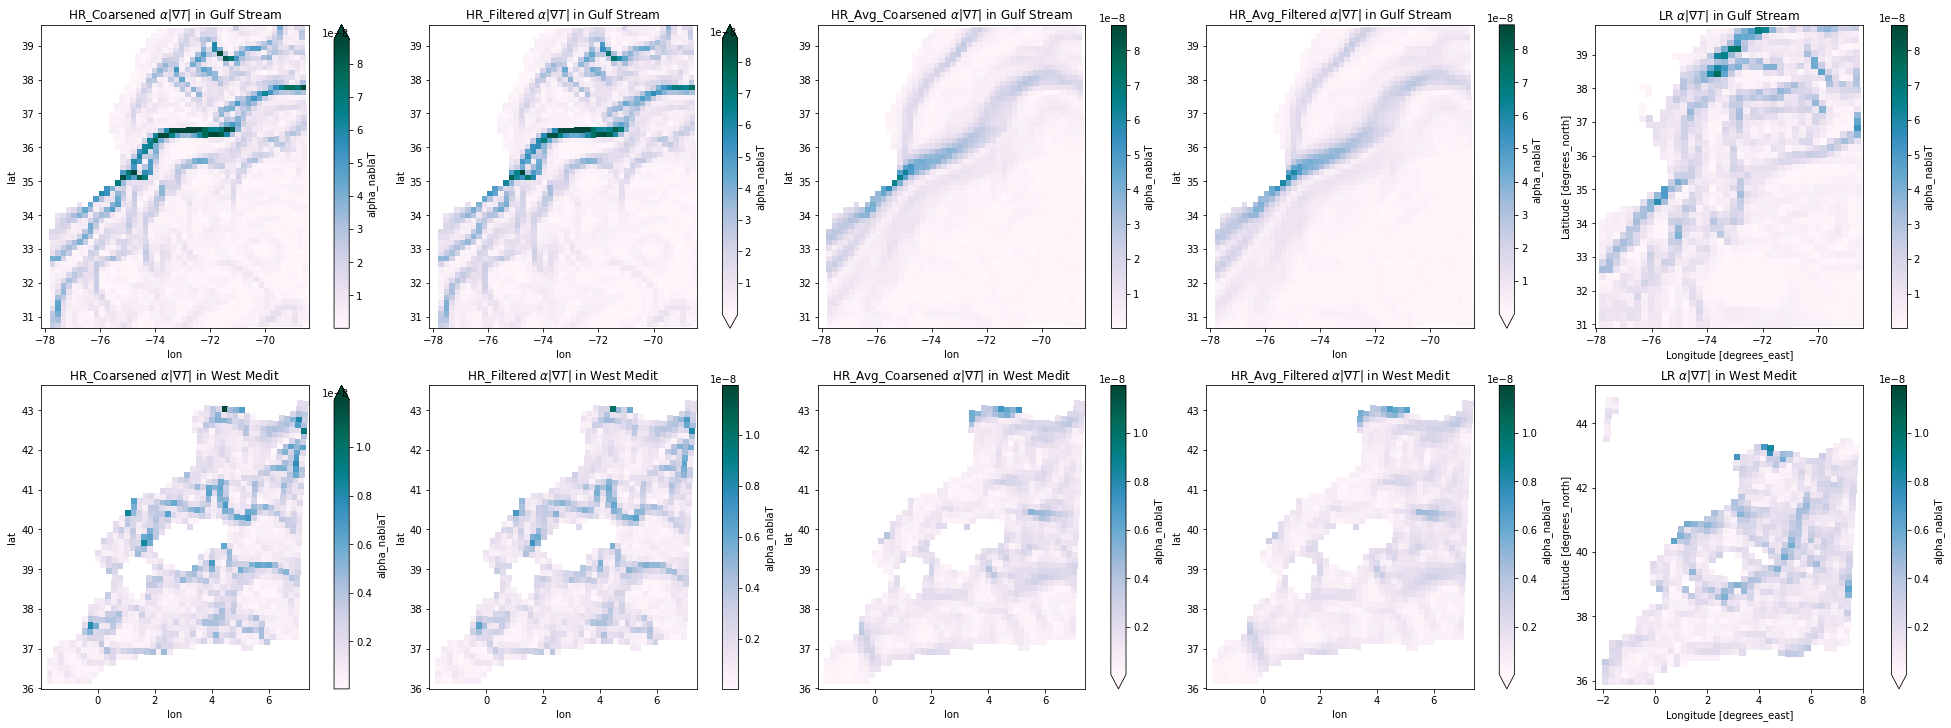

In [38]:
fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(27,10), constrained_layout=True)
for region in [0,1] :
    norm = colors.Normalize(vmin=data[region]['HR_Filtered'].isel(time_counter=0).alpha_nablaT.min().values, \
                            vmax=data[region]['HR_Filtered'].isel(time_counter=0).alpha_nablaT.max().values)
    row = region 
    for col, dataSetKey in enumerate(['HR_Coarsened', 'HR_Filtered', 'HR_Avg_Coarsened', 'HR_Avg_Filtered', 'LR']) :
        data[region][dataSetKey].isel(time_counter=-1).alpha_nablaT[bord_cut].plot(x='lon', y='lat', ax=axis[row,col], cmap='PuBuGn', norm=norm)
        axis[row,col].set(title=dataSetKey + r' $\alpha |\nabla T| $ in ' + data[region]['label'])

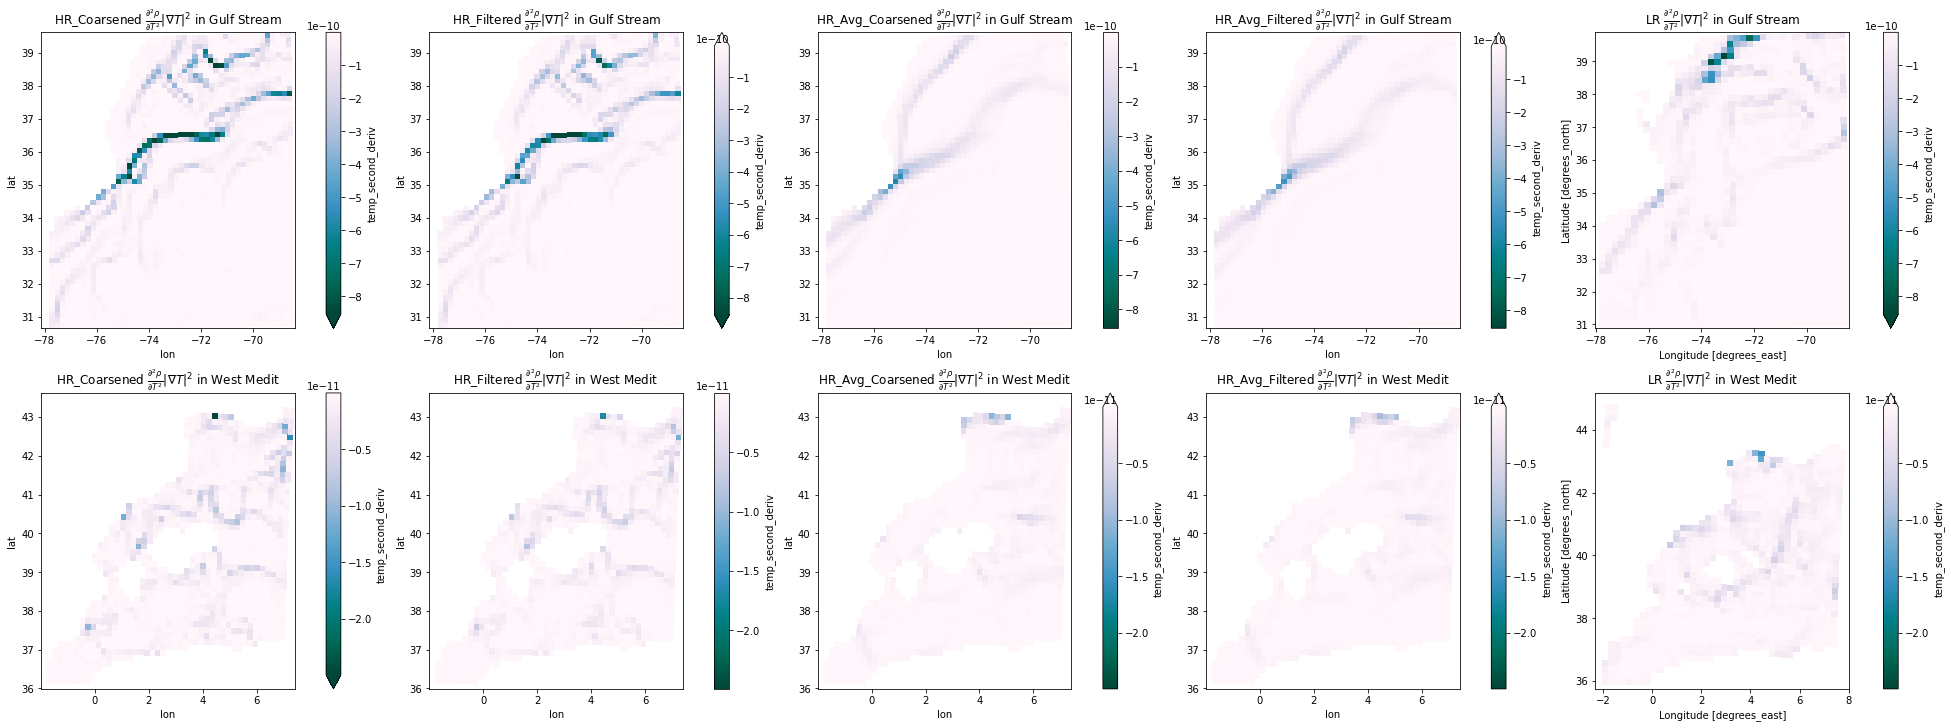

In [39]:
fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(27,10), constrained_layout=True)
for region in [0,1] :
    norm = colors.Normalize(vmin=data[region]['HR_Filtered'].isel(time_counter=0).temp_second_deriv.min().values, \
                            vmax=data[region]['HR_Filtered'].isel(time_counter=0).temp_second_deriv.max().values)
    row = region 
    for col, dataSetKey in enumerate(['HR_Coarsened', 'HR_Filtered', 'HR_Avg_Coarsened', 'HR_Avg_Filtered', 'LR']) :
        data[region][dataSetKey].isel(time_counter=-1).temp_second_deriv[bord_cut].plot(x='lon', y='lat', ax=axis[row,col], cmap='PuBuGn_r', norm=norm)
        axis[row,col].set(title=dataSetKey + r' $\frac{\partial^2 \rho}{\partial T^2} |\nabla T|^2$ in ' + data[region]['label'])

# Spatial covariance

In [40]:
%%time 
for region in range(len(data)) :
    for dataKey in ['HR_Coarsened', 'HR_Filtered'] :
        ds = data[region][dataKey]
        for quantity in ['grad_temp', 'grad_sal', 'alpha_nablaT', 'beta_nablaS', 'spicyness', 'buoyancy', 'temp_second_deriv', 'mixed_second_deriv', 'sal_second_deriv','total_second_deriv'] :    
            ds[quantity+'_dens_covar'] = xr.corr(ds[quantity], ds['sigma0_delta'], dim=['x', 'y']).compute()

CPU times: user 1.25 s, sys: 91.9 ms, total: 1.35 s
Wall time: 4.27 s


In [41]:
quantity_labels=[r'$|\nabla T|$', r'$|\nabla S|$',\
                 r'$\alpha |\nabla T|$', r'$\beta |\nabla S|$', r'$\nabla s=\alpha |\nabla T|+\beta |\nabla S|$', r'$\nabla b=\alpha |\nabla T|-\beta |\nabla S|$', \
                 r'$\frac{\partial^2 \rho}{\partial T^2} |\nabla T|^2$', r'$\frac{\partial^2 \rho}{\partial T \partial S} |\nabla T|~|\nabla S|$', \
                 r'$\frac{\partial^2 \rho}{\partial S^2} |\nabla S|^2$',\
                r'$\frac{\partial^2 \rho}{\partial T^2} |\nabla T|^2 + \frac{\partial^2 \rho}{\partial T \partial S} |\nabla T|~|\nabla S| + \frac{\partial^2 \rho}{\partial S^2} |\nabla S|^2$']

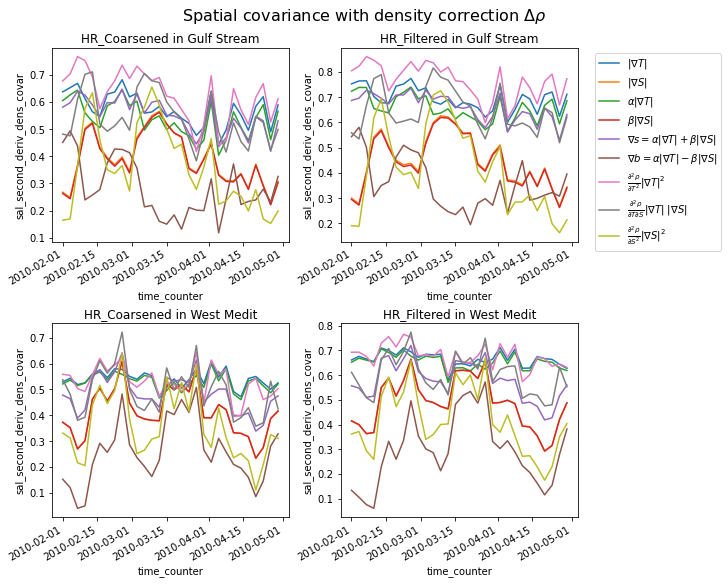

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,8), constrained_layout=True)
fig.suptitle(r'Spatial covariance with density correction $\Delta \rho$', size=16)
for region in range(len(data)) :
    row=region
    for col, dataKey in enumerate(['HR_Coarsened', 'HR_Filtered']) :
        ds = data[region][dataKey]
        for i,quantity in enumerate(['grad_temp', 'grad_sal','alpha_nablaT', 'beta_nablaS', 'spicyness', 'buoyancy', 'temp_second_deriv', 'mixed_second_deriv', 'sal_second_deriv']) :
            abs(ds[quantity+'_dens_covar']).plot(ax=ax[row,col], label=quantity_labels[i])
            ax[row,col].set(title=dataKey+' in '+data[region]['label'])
ax[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Histograms of temperature and salinity

In [43]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t).where(dataSet.tmask >0), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum()).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = hist/hist.sum()
    return norm_hist

In [44]:
nb_of_bins = 150

In [45]:
%%timeit
for region in [0,1] :
    for dataSetKey in ['HR', 'HR_Coarsened', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered'] :
        new_key = dataSetKey + '_hist_temp_sal'
        data[region][new_key] = compute_2D_histogram(data[region][dataSetKey].\
                                                           chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), 'sosaline', 'sosstsst', nb_of_bins).compute()

3.85 s ± 78.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, cmap, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmap, shading='auto', alpha=0.95)
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x)
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins])
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

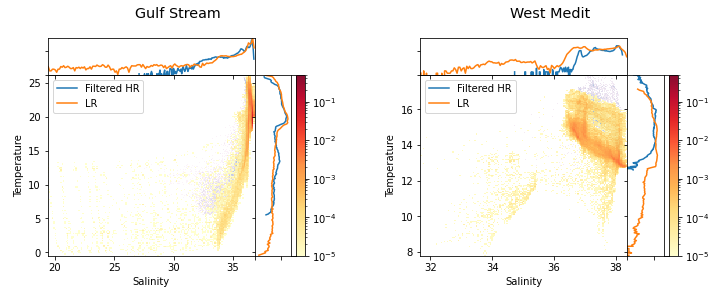

In [47]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for region in [0,1] :
    subfigs[region].suptitle(data[region]['label'], fontsize='x-large')
    sel_data0 = data[region]['HR_Filtered_hist_temp_sal']
    #sel_data1 = data[region]['Avg_Filtered_hist_temp_sal']
    sel_data1 = data[region]['LR_hist_temp_sal']
    big_ax = subfigs[region].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[region].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[region].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[region].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data0,'PuBuGn', 'sosaline_bin', 'sosstsst_bin', top_ax, right_ax, big_ax)
    #margin_hist(sel_data1, 'YlOrRd', 'sosaline_bin', 'sosstsst_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data1, 'YlOrRd', 'sosaline_bin', 'sosstsst_bin', top_ax, right_ax, big_ax)
    big_ax.set(xlabel='Salinity', ylabel='Temperature')
    big_ax.legend(handles=top_ax.lines, labels=['Filtered HR', 'LR'], loc='upper left')

    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

# Histograms of gradients

In [48]:
%%time
for region in [0,1] :
    new_key = 'HR_Coarsened_hist_grads_sqr'
    data[region][new_key] = compute_2D_histogram(data[region]['HR_Coarsened'], 'grad_sal_sqr', 'grad_temp_sqr', nb_of_bins).compute()
    for dataSetKey in ['HR', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered'] :
        new_key = dataSetKey + '_hist_grads_sqr'
        bins = [data[region]['HR_Coarsened_hist_grads_sqr'].grad_sal_sqr_bin.values, data[region]['HR_Coarsened_hist_grads_sqr'].grad_temp_sqr_bin.values]
        data[region][new_key] = compute_2D_histogram(data[region][dataSetKey], 'grad_sal_sqr', 'grad_temp_sqr', nb_of_bins, bins=bins).compute()

CPU times: user 312 ms, sys: 151 ms, total: 462 ms
Wall time: 2.31 s


In [49]:
%%time
# Gadients in x-direction
for region in [0,1] :
    new_key = 'HR_Coarsened_hist_grads_x'
    data[region][new_key] = compute_2D_histogram(data[region]['HR_Coarsened'], 'gradx_sal', 'gradx_temp', nb_of_bins).compute()
    for dataSetKey in ['HR', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered']  :
        new_key = dataSetKey + '_hist_grads_x'
        bins = [data[region]['HR_Coarsened_hist_grads_x'].gradx_sal_bin.values, data[region]['HR_Coarsened_hist_grads_x'].gradx_temp_bin.values]
        data[region][new_key] = compute_2D_histogram(data[region][dataSetKey], 'gradx_sal', 'gradx_temp', nb_of_bins, bins=bins).compute()

CPU times: user 311 ms, sys: 161 ms, total: 472 ms
Wall time: 2.62 s


In [50]:
%%time
# Gadients in y-direction
for region in [0,1] :
    new_key = 'HR_Coarsened_hist_grads_y'
    data[region][new_key] = compute_2D_histogram(data[region]['HR_Coarsened'], 'grady_sal', 'grady_temp', nb_of_bins).compute()
    for dataSetKey in  ['HR', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered']  :
        new_key = dataSetKey + '_hist_grads_y'
        bins = [data[region]['HR_Coarsened_hist_grads_y'].grady_sal_bin.values, data[region]['HR_Coarsened_hist_grads_y'].grady_temp_bin.values]
        data[region][new_key] = compute_2D_histogram(data[region][dataSetKey], 'grady_sal', 'grady_temp', nb_of_bins, bins=bins).compute()

CPU times: user 309 ms, sys: 152 ms, total: 461 ms
Wall time: 2.59 s


## Squares of gradients

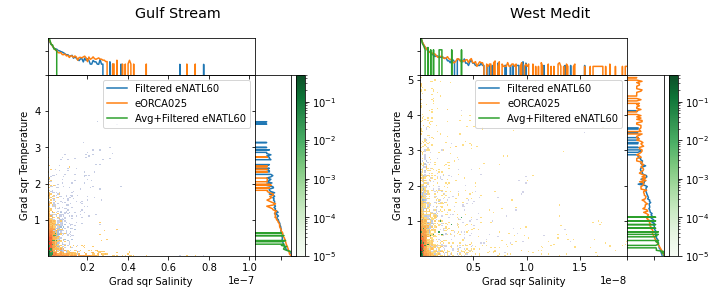

In [51]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for region in [0,1] :
    subfigs[region].suptitle(data[region]['label'], fontsize='x-large')
    sel_data1 = data[region]['HR_Filtered_hist_grads_sqr']
    sel_data2 = data[region]['LR_hist_grads_sqr']
    sel_data3 = data[region]['HR_Avg_Filtered_hist_grads_sqr']
    big_ax = subfigs[region].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[region].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[region].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[region].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data1,'PuBuGn', 'grad_sal_sqr_bin', 'grad_temp_sqr_bin', top_ax, right_ax, big_ax)
    margin_hist(sel_data2,'YlOrRd', 'grad_sal_sqr_bin', 'grad_temp_sqr_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data3, 'Greens', 'grad_sal_sqr_bin', 'grad_temp_sqr_bin', top_ax, right_ax, big_ax)
    big_ax.set(xlabel='Grad sqr Salinity', ylabel='Grad sqr Temperature')
    big_ax.legend(handles=top_ax.lines, labels=['Filtered eNATL60', 'eORCA025', 'Avg+Filtered eNATL60'], loc='best')
    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

## Gradients in X-direction

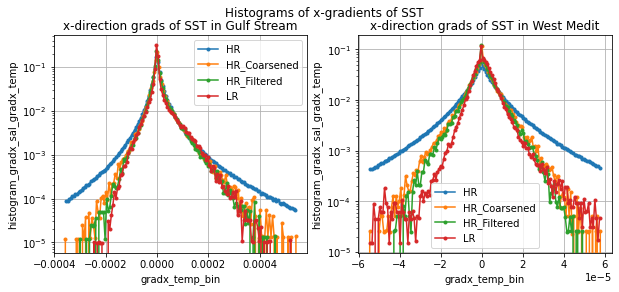

In [52]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
fig.suptitle('Histograms of x-gradients of SST')
for region in [0,1] :
    for dataSetKey in ['HR', 'HR_Coarsened', 'HR_Filtered', 'LR'] :
        new_key = dataSetKey + '_hist_grads_x'
        data[region][new_key].sum(dim='gradx_sal_bin').plot(ax=ax[region], label=dataSetKey, ls='-', marker='.')
    ax[region].set(title='x-direction grads of SST in ' + data[region]['label'], yscale='log'); ax[region].grid(True)
    ax[region].legend()

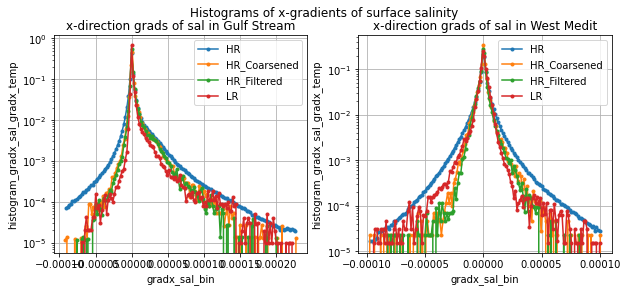

In [53]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
fig.suptitle('Histograms of x-gradients of surface salinity')
for region in [0,1] :
    for dataSetKey in ['HR', 'HR_Coarsened', 'HR_Filtered', 'LR'] :
        new_key = dataSetKey + '_hist_grads_x'
        data[region][new_key].sum(dim='gradx_temp_bin').plot(ax=ax[region], label=dataSetKey, ls='-', marker='.')
    ax[region].set(title='x-direction grads of sal in ' + data[region]['label'], yscale='log'); ax[region].grid(True)
    ax[region].legend()

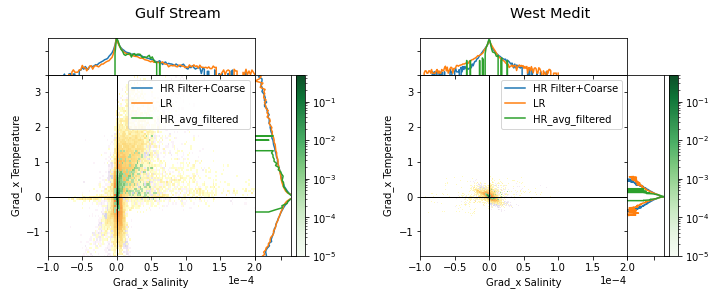

In [54]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for region in [0,1] :
    subfigs[region].suptitle(data[region]['label'], fontsize='x-large')
    sel_data1 = data[region]['HR_Filtered_hist_grads_x']
    sel_data15 = data[region]['HR_Avg_Filtered_hist_grads_x']
    sel_data2 = data[region]['LR_hist_grads_x']
    big_ax = subfigs[region].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[region].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[region].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[region].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data1,'PuBuGn', 'gradx_sal_bin', 'gradx_temp_bin', top_ax, right_ax, big_ax)
    margin_hist(sel_data2, 'YlOrRd', 'gradx_sal_bin', 'gradx_temp_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data15,'Greens', 'gradx_sal_bin', 'gradx_temp_bin', top_ax, right_ax, big_ax)
    big_ax.set(xlabel='Grad_x Salinity', ylabel='Grad_x Temperature')
    big_ax.ticklabel_format(useOffset=False, scilimits=(-4,6))
    big_ax.legend(handles=top_ax.lines, labels=['HR Filter+Coarse', 'LR', 'HR_avg_filtered'], loc='best')
    big_ax.axvline(x=0, color='k', lw=1); big_ax.axhline(y=0, color='k', lw=1)
    big_ax.set(xlim=[-0.0001, 0.0002], ylim=[-0.00017, 0.00035])

    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

## Gradients in Y-direction

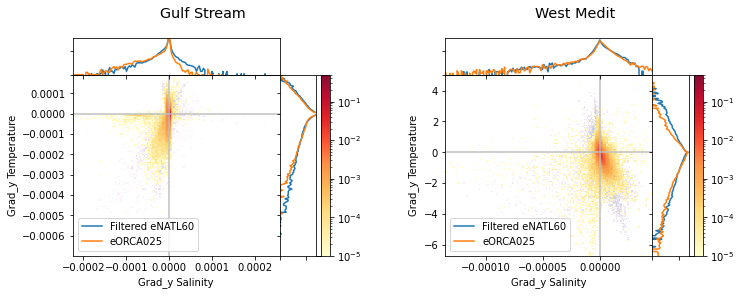

In [55]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for region in [0,1] :
    subfigs[region].suptitle(data[region]['label'], fontsize='x-large')
    sel_data1 = data[region]['HR_Filtered_hist_grads_y']
    sel_data2 = data[region]['LR_hist_grads_y']
    big_ax = subfigs[region].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[region].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[region].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[region].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data1,'PuBuGn', 'grady_sal_bin', 'grady_temp_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 'YlOrRd', 'grady_sal_bin', 'grady_temp_bin', top_ax, right_ax, big_ax)
    big_ax.set(xlabel='Grad_y Salinity', ylabel='Grad_y Temperature')
    big_ax.legend(handles=top_ax.lines, labels=['Filtered eNATL60', 'eORCA025'], loc='lower left')
    big_ax.axvline(x=0, color='silver', lw=1.5); big_ax.axhline(y=0, color='silver', lw=1.5)

    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

# Statistical moments of gradients

In [56]:
keys = ['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']

In [57]:
%%time
for region in [0,1] :
    for dataSetKey in ['HR', 'HR_Coarsened', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered'] :
        curDS = data[region][dataSetKey + '_hist_grads_x']
        [curDS.attrs['nobs'], curDS.attrs['minmax'], curDS.attrs['mean'], curDS.attrs['variance'], curDS.attrs['skewness'], curDS.attrs['kurtosis']] \
        = describe(data[region][dataSetKey].gradx_temp, axis=None, nan_policy='omit')

        curDS = data[region][dataSetKey + '_hist_grads_y']
        [curDS.attrs['nobs'], curDS.attrs['minmax'], curDS.attrs['mean'], curDS.attrs['variance'], curDS.attrs['skewness'], curDS.attrs['kurtosis']] \
        = describe(data[region][dataSetKey].grady_temp, axis=None, nan_policy='omit')

CPU times: user 4.46 s, sys: 1.15 s, total: 5.61 s
Wall time: 6.18 s


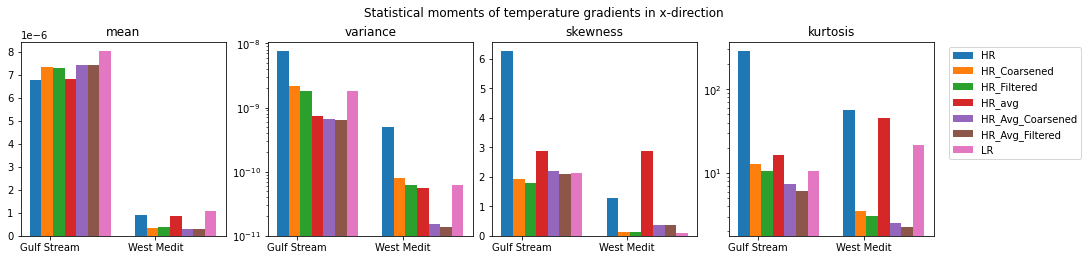

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Statistical moments of temperature gradients in x-direction')
x = np.arange(2)
bar_width = 0.11
for index, stat_moment_key in enumerate(['mean', 'variance', 'skewness', 'kurtosis']) :
    for bar_shift, dsKey in enumerate(['HR', 'HR_Coarsened', 'HR_Filtered', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered',  'LR',]) :
        ax[index].bar(x+bar_shift*bar_width, [data[region][dsKey+'_hist_grads_x'].attrs[stat_moment_key] for region in [0,1]], width=bar_width, label=dsKey)
    ax[index].set_xticks(x + 1.25*bar_width)
    ax[index].set_xticklabels([data[region]['label'] for region in [0,1]])
    ax[index].set(title=stat_moment_key)
    if (index%2 == 1) : ax[index].set(yscale='log')
    if (index%2 == 0) : ax[index].set(yscale='linear')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

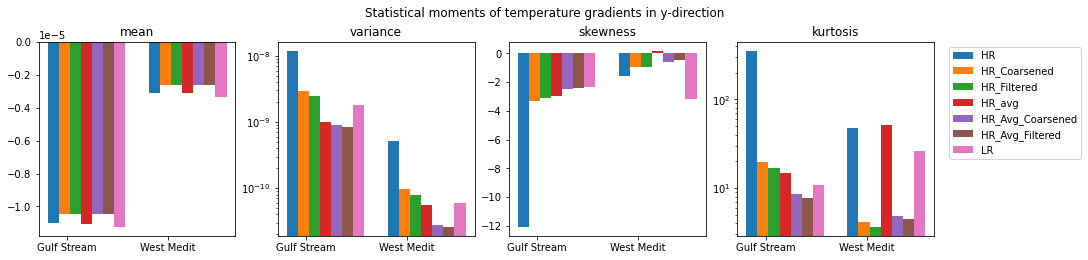

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Statistical moments of temperature gradients in y-direction')
x = np.arange(2)
bar_width = 0.11
for index, stat_moment_key in enumerate(['mean', 'variance', 'skewness', 'kurtosis']) :
    for bar_shift, dsKey in enumerate(['HR', 'HR_Coarsened', 'HR_Filtered', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered', 'LR']) :
        ax[index].bar(x+bar_shift*bar_width, [data[region][dsKey+'_hist_grads_y'].attrs[stat_moment_key] for region in [0,1]], width=bar_width, label=dsKey)
    ax[index].set_xticks(x + 1.25*bar_width)
    ax[index].set_xticklabels([data[region]['label'] for region in [0,1]])
    ax[index].set(title=stat_moment_key)
    if (index%2 == 1) : ax[index].set(yscale='log')
    if (index%2 == 0) : ax[index].set(yscale='linear')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Joint histograms of density correction and temperature derivatives

In [60]:
%%timeit
for region in [0,1] :
    for dataSetKey in ['HR_Coarsened', 'HR_Filtered', 'HR_Avg_Coarsened', 'HR_Avg_Filtered'] :
        new_key = dataSetKey + '_hist_deriv2_temp_dens'
        data[region][new_key] = compute_2D_histogram(data[region][dataSetKey], 'temp_second_deriv', 'sigma0_delta', nb_of_bins).compute()

1.03 s ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


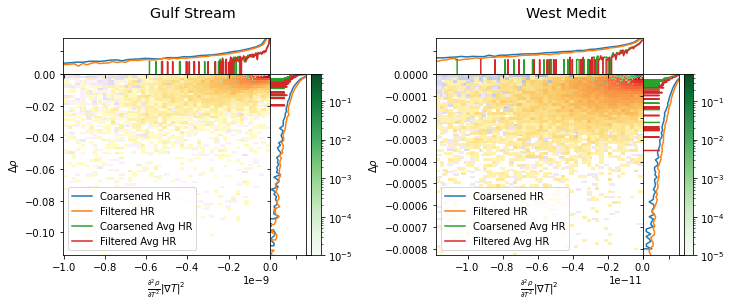

In [61]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
bins = ['temp_second_deriv_bin', 'sigma0_delta_bin']
for region in [0,1] :
    subfigs[region].suptitle(data[region]['label'], fontsize='x-large')
    #sel_data0 = data[region]['HR_Coarsened_hist_deriv2_temp_dens']
    #sel_data1 = data[region]['HR_Filtered_hist_deriv2_temp_dens']
    big_ax = subfigs[region].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[region].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[region].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[region].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(data[region]['HR_Coarsened_hist_deriv2_temp_dens'],'PuBuGn', bins[0], bins[1], top_ax, right_ax, big_ax)
    margin_hist(data[region]['HR_Filtered_hist_deriv2_temp_dens'], 'YlOrRd', bins[0], bins[1], top_ax, right_ax, big_ax)
    margin_hist(data[region]['HR_Avg_Coarsened_hist_deriv2_temp_dens'], 'Greens', bins[0], bins[1], top_ax, right_ax, big_ax)
    hist_joint = margin_hist(data[region]['HR_Avg_Filtered_hist_deriv2_temp_dens'], 'Greens', bins[0], bins[1], top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'$\frac{\partial^2 \rho}{\partial T^2} |\nabla T|^2$', ylabel=r'$\Delta \rho$')
    big_ax.legend(handles=top_ax.lines, labels=['Coarsened HR', 'Filtered HR', 'Coarsened Avg HR','Filtered Avg HR'], loc='lower left')
    big_ax.set(xlim=[0.25*data[region]['HR_Coarsened_hist_deriv2_temp_dens']['temp_second_deriv_bin'].min(),0],\
              ylim=[0.5*data[region]['HR_Coarsened_hist_deriv2_temp_dens']['sigma0_delta_bin'].min(),0])
    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()